In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import find_peaks
from data_access import metadata_from_path

Finding statistical measures from the dataset

In [ ]:
data_path = 'data/2/exp02H20141204_17h28.csv'
FISH_ATTR_COUNT = 3 # how manny bits of info for each fish

experement = pd.read_csv(data_path)
a = experement.iloc[31000:,:]


print(a.head(5))

             X1        Y1        H1        X2        Y2        H2
31000  95.89994  310.4725 -204.5278  14.61787  271.4049 -198.0561
31001  95.37074  310.5196 -204.5161  13.35791  271.4748 -198.0515
31002  94.24655  310.8535 -204.5027  11.90850  271.7569 -198.0579
31003  93.90428  310.8884 -204.4952  10.61782  271.9382 -198.0679
31004  93.21094  311.1387 -204.5098   8.83675  272.0749 -198.0566


In [ ]:
n_fish = experement.shape[1]//FISH_ATTR_COUNT
cols = [i+2 for i in range(0,n_fish*FISH_ATTR_COUNT,FISH_ATTR_COUNT)]
headings = a.iloc[:, cols]
print(headings.describe())

                  H1             H2
count  176826.000000  174201.000000
mean     -491.745612    -462.815447
std       223.375882     188.195076
min      -881.130200    -767.319900
25%      -681.736325    -627.988500
50%      -501.115400    -495.781800
75%      -282.852950    -305.932900
max      -152.695100    -166.149700


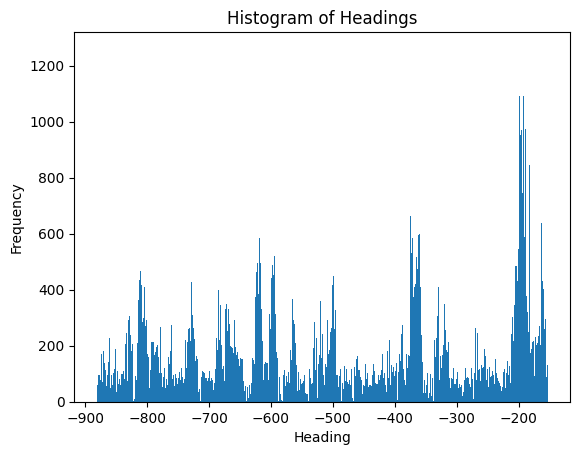

In [ ]:

plt.hist(headings["H1"], bins=1000)
plt.xlabel("Heading")
plt.ylabel("Frequency")
plt.title("Histogram of Headings")
plt.show()

Fig 1

               X1          Y1          H1          X2          Y2          H2
count  710.000000  710.000000  710.000000  710.000000  710.000000  710.000000
mean    10.701123  -31.538931 -209.885655   55.511549  -51.429348 -209.841270
std    211.956828  204.756438    1.649193  216.123540  196.466624    1.528144
min   -328.759300 -273.285200 -213.018200 -301.475200 -312.080700 -212.655400
25%   -196.506375 -230.279800 -211.047775 -137.570550 -232.093050 -211.055100
50%     61.736170  -62.864525 -210.283850  115.839050  -91.050705 -209.697250
75%    218.758350  174.831950 -208.585075  255.425500  112.383525 -208.994600
max    271.263500  310.161300 -206.390600  321.467800  288.627100 -206.733700
Differance in heading after one lap 2.1096306016716913π


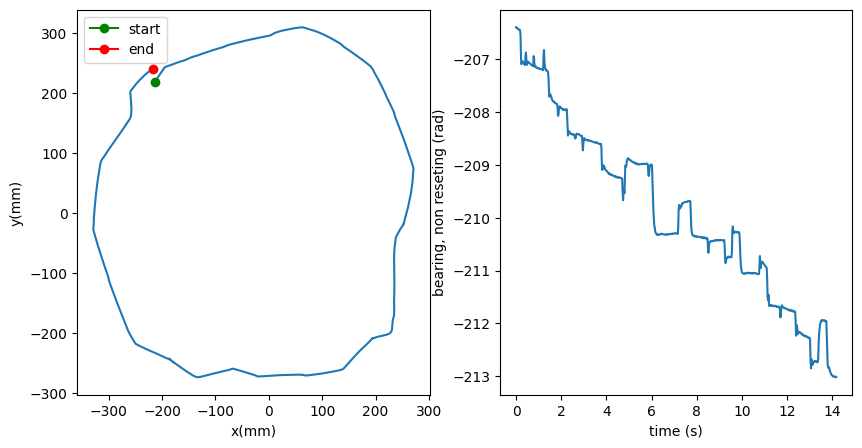

In [ ]:

fps = metadata_from_path(data_path)['Fps']

a_onelap = a.iloc[33000:33710, :]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))   

ax1.plot(a_onelap.iloc[:,0], a_onelap.iloc[:,1])
ax1.plot(a_onelap.iloc[0,0], a_onelap.iloc[0,1],marker = "o", color = "green", label = "start")
ax1.plot(a_onelap.iloc[-1,0], a_onelap.iloc[-1,1], marker = "o", color = "red", label = "end")
ax1.set_xlabel("x(mm)")
ax1.set_ylabel("y(mm)")
ax1.legend()

ax2.plot(np.arange(len(a_onelap.iloc[:,2]))/fps, a_onelap.iloc[:,2])
ax2.set_xlabel("time (s)")
ax2.set_ylabel("bearing, non reseting (rad)")

print(a_onelap.describe())
differance = abs(a_onelap["H1"].max()-a_onelap["H1"].min())
print(f"Differance in heading after one lap {differance/math.pi}π")

plt.show()

Fig 2

Trying to use a normal distibutiona and signifiance level to identiy turns. 

In [ ]:

turn_rate = headings["H1"].diff() * fps

mu = turn_rate.mean()
std = turn_rate.std()

#Bounds = mu +- Z * std
#At 5% significance level, Z = 19.6 (two tailed)

lower_bound = mu - 1.96*std
upper_bound = mu + 1.96*std

turn_events = turn_rate[(turn_rate < lower_bound) | (turn_rate > upper_bound)]

print(turn_events)

31044     10.135
31045     13.855
31085      6.785
31105      9.595
31106     13.220
           ...  
207749    -9.780
207770   -10.390
207792     8.345
207813    14.045
207814    12.905
Name: H1, Length: 11854, dtype: float64


Text(0, 0.5, 'Value of time diffs')

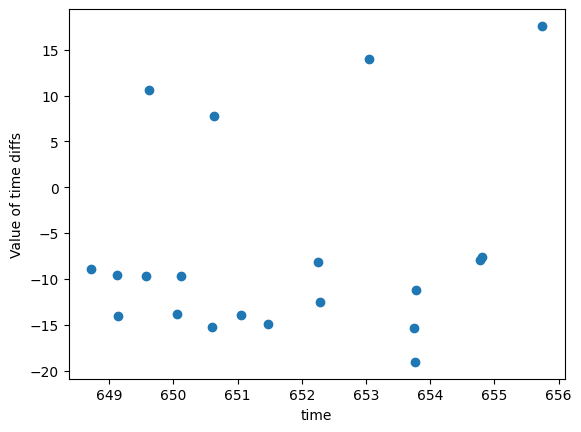

In [28]:
section_range = slice(100, 120)

frames = turn_events.index.to_numpy()
time = frames/fps

turn_diffs = turn_events.values

plt.scatter(time[section_range], turn_diffs[section_range])
plt.xlabel('time')
plt.ylabel("Value of time diffs")

Finds too many. At 55 SigLvl, 5% of frames will be a turn or 2.5 turns a second. 

Alternative method (suggested by Gemini) is uing a differance over a moving window i.e. 

In [48]:
window_size = 150

sustained_turn = headings['H1'].diff(periods=window_size)

turn_threshold = np.pi

significant_events = sustained_turn[abs(sustained_turn) > turn_threshold]

print(max(significant_events))

8.144600000000082


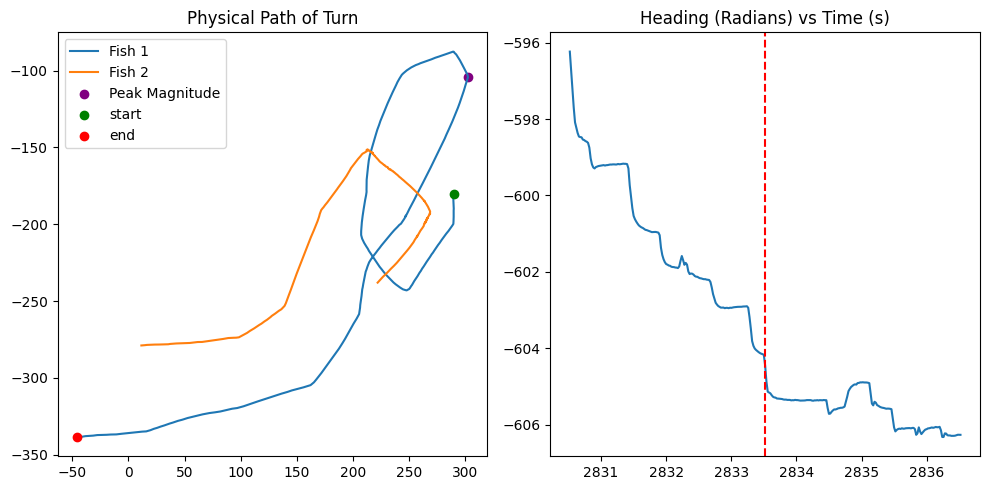

In [ ]:
turn_idx = sustained_turn.abs().idxmax()

window = a.loc[turn_idx-window_size : turn_idx+window_size]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(window['X1'], window['Y1'], label='Fish 1')
plt.plot(window['X2'], window['Y2'], label='Fish 2')

plt.scatter(a.loc[turn_idx, 'X1'], a.loc[turn_idx, 'Y1'], color='purple', label='Peak Magnitude')

plt.scatter(window.iloc[0]['X1'], window.iloc[0]['Y1'], marker="o", color="green", label="start", zorder=5)
plt.scatter(window.iloc[-1]['X1'], window.iloc[-1]['Y1'], marker="o", color="red", label="end", zorder=5)

plt.title("Physical Path of Turn")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(window.index / fps, window['H1'])
plt.axvline(turn_idx / fps, color='red', linestyle='--')
plt.title("Heading (Radians) vs Time (s)")

plt.tight_layout()
plt.show()

significant_events contains all the frames where the over the past "window_size' there was a change of 180degrees or pi radians.
Given a fps of 50 and 150 frame window this is looking over 3 seconds. Given one full lap takes around 14s (fig 2), this shoud only find abnormily fast changes in direction, idealy u turns. 

This still leaves the issue of finding the point of greatest turn within these events. 

In [ ]:
#Help from gemini, have read thru documentation but not verified as of 17/02/26 16:24


peaks, _ = find_peaks(sustained_turn.abs().fillna(0), 
                      height=np.pi, 
                      distance=150)

print(f"Before, find_peaks applied, {len(sustained_turn)} turns found")
print(f"After, found {len(peaks)} unique turn events.")
#Result seems to make sense

Before, find_peaks applied, 176826 turns found
After, found 234 unique turn events.


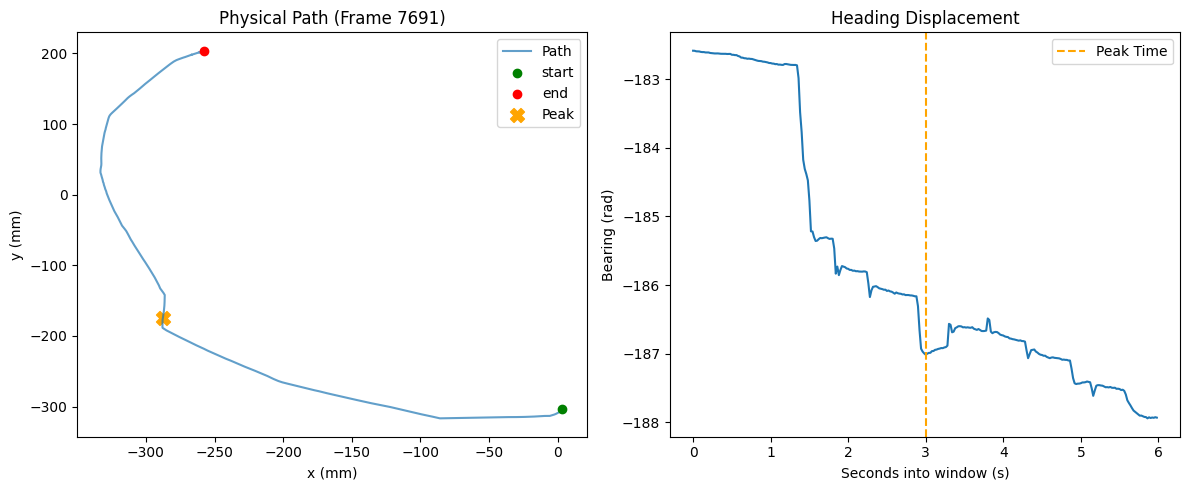

In [ ]:
def plot_path_and_bearings(df: pd.DataFrame, index: int, window: int = 150, fps:int = fps):
    start_idx = max(0, index - window)
    end_idx = min(len(df), index + window)
    plotting_range = slice(start_idx, end_idx)
    
    sub_df = df.iloc[plotting_range]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(sub_df.iloc[:, 0], sub_df.iloc[:, 1], label="Path", alpha=0.7)
    
    ax1.scatter(sub_df.iloc[0, 0], sub_df.iloc[0, 1], color="green", label="start", zorder=5)
    ax1.scatter(sub_df.iloc[-1, 0], sub_df.iloc[-1, 1], color="red", label="end", zorder=5)
    
    ax1.scatter(df.iloc[index, 0], df.iloc[index, 1], color="orange", marker="X", s=100, label="Peak")
    
    ax1.set_xlabel("x (mm)")
    ax1.set_ylabel("y (mm)")
    ax1.set_title(f"Physical Path (Frame {index})")
    ax1.legend()

    local_time = np.arange(len(sub_df)) / fps 
    
    # Extract the heading column (H1 is index 2)
    heading_values = sub_df.iloc[:, 2].values 
    
    ax2.plot(local_time, heading_values)
    
    # Mark the peak relative to the start of this window
    peak_relative_time = (index - start_idx) / fps
    ax2.axvline(peak_relative_time, color='orange', linestyle='--', label="Peak Time")
    
    ax2.set_xlabel("Seconds into window (s)")
    ax2.set_ylabel("Bearing (rad)")
    ax2.set_title("Heading Displacement")
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_path_and_bearings(a, peaks[2])

This mostly works but sometimes such as the third "peak' is just because the fish makes a weird movement. Not sure how to fix. 